# Notebook du projet : Analyse des discours de la Banque Centrale Européenne

Dans ce notebook, nous cherchons à analyser différents aspects des discours du comité exécutif de la BCE depuis sa création.

## Package installation

In [1]:
### Installation de tous les packages nécessaires à l'exécution du notebook 
# Cette étape peut être assez longue

# !pip install -r requirements.txt

## Imports

In [4]:
import time
import datetime
import copy as c
import random
import collections
import re
from itertools import chain


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default='iframe'

import langdetect
import nltk
import gensim
import datasets
import pyLDAvis
import pyLDAvis.gensim_models
from tqdm import tqdm_notebook
tqdm_notebook().pandas()

# pour l'analyse de sentiments
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pysentiment2 as ps
lm = ps.LM()


import yfinance as yf

# pour importer:exporter des données vers MinIO (répertoire SSP Cloud)
import s3fs
import os

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# Fichiers .py du projet
import webscrap
import cleanup 
import statdes
import basic_nlp



C:\Users\Antoine\AppData\Local\Temp/ipykernel_22696/3404217054.py:26: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0it [00:00, ?it/s]

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\Antoine\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Antoine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Antoine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Récupération des discours depuis le site de la BCE

Le dataset des discours est mis à jour tous les mois. Ainsi, même s'il est possible de changer le lien "à la main", il parait pertinent d'utiliser le webscraping pour obtenir la dernière version des données automatiquement. On utilise pour cela les fonctions du fichier *webscrap.py*.

In [19]:
# URL de la page de téléchargement du dataset sur le site de la BCE
url_ecb_download = "https://www.ecb.europa.eu/press/key/html/downloads.en.html"

# On fait du webscraping pour obtenir le lien de la dernière version du dataset des discours
url = "https://www.ecb.europa.eu" + webscrap.get_dataset_url(url_ecb_download)

# On affiche la date de la dernière mise à jour du fichier .csv
print(webscrap.last_update_dataset(url_ecb_download))

df = pd.read_csv(url, sep = "|", encoding = 'utf-8')
print("Il y a ", len(df), "discours dans le dataset.")

last update: 01 January 2022
Il y a  2553 discours dans le dataset


## Nettoyage des données récupérées

Pour le nettoyage des données récupérées, on utilise les fonctions du fichier *cleanup.py*.

Après une analyse préliminaire, on remarque que pour certains discours, on a seulement le titre et le speaker mais le contenu est *NaN*. Il faut donc mettre de côté tous ces discours sans contenu. Ce cas se présente seulement pour 39 discours (soit 1,5% de la base de données). Ainsi, il n'est pas problématique de les retirer.

In [20]:
# On nettoie les données et on affiche les valeurs manquantes
df = cleanup.clean_missing_data(df)

date         0
speakers     2
title        0
subtitle     1
contents    39
dtype: int64


De plus, on décide de ne garder que les discours en anglais. En effet, avoir des discours en plusieurs langues va grandement compliquer le traitement et l'analyse, d'autant plus que la majorité des discours sont en anglais. Pour trier les discours selon leur langue, on a comparé plusieurs méthodes qu'on peut retrouver dans le notebook *Tests-LanguageDetection.ipynb* du dossier *tests*. On utilise ici la méthode qu'on juste la plus adaptée à notre projet alliant rapidité et une efficacité convenable : on analyse les 2000 premiers caractères des discours avec la fonction *detect* de la librairie langdetect.

In [21]:
df = cleanup.keep_english(df)
print("Il reste", len(df), "discours dans le dataframe.")

Proportion de discours en anglais :  0.9287703939514524
Temps pris par cette méthode :  20.47025752067566
Il reste 2334 discours dans le dataframe.


Pour la suite de l'analyse, en particulier pour les statistiques descriptives et les graphiques, il parait opportun d'ajouter au dataframe des colonnes pour le jour, le mois et l'année établis à partir de la colonne "date".

In [22]:
df = cleanup.add_date(df)

C:\Users\Antoine\central-bank-speech-analysis\cleanup.py:52: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Antoine\central-bank-speech-analysis\cleanup.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Antoine\central-bank-speech-analysis\cleanup.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



On peut enregistrer le dataframe pour ne pas devoir relancer le début à chaque fois. Pour des questions pratiques, on préférera récupérer directement le fichier depuis  SSP Cloud.

In [7]:
# cleanup.todisk(df)
# df = cleanup.fromdisk()

#On récupère directement le dataset nettoyé à partir de MinIO
url="https://minio.lab.sspcloud.fr/aissac/Projet_Python_2A/clean_ecb_speeches_dataset.csv"

df=pd.read_csv(url,sep = ",",encoding='utf-8')

# Statistiques descriptives de notre jeu de données

Avant de commencer l'analyse de sentiments ou le NLP, on analyse d'abord notre jeu de données en faisant des statistiques descriptives en utilisant les fonctions du fichier *statdes.py*.

## Répartition des discours dans le temps

### Nombre de discours par an

<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par Année'}, xlabel='Année'>

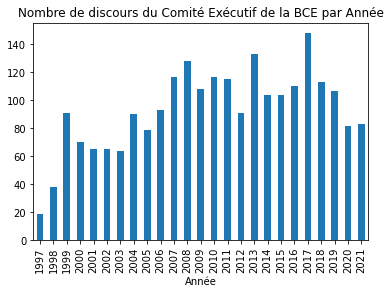

In [8]:
statdes.count_speeches(df, kind = 'bar')

Depuis la création de la Banque Centrale européenne, on constate une hausse significative du nombre de discours du comité exécutif de la BCE : aucune année ne dépasse 100 discours jusqu'en 2006 alors que depuis le nombre de discours n'a été inférieur à 100 qu'en 2012, 2020 et 2021, avec une situation exceptionnelle (crise sanitaire mondiale) pour ces deux dernières années. On pourrait émettre l'hypothèse que les pics du graphique correspondent aux crises : crise des subprimes en 2008, Brexit en 2017 par exemple.

### Nombre de discours selon les mois

<Figure size 432x288 with 0 Axes>

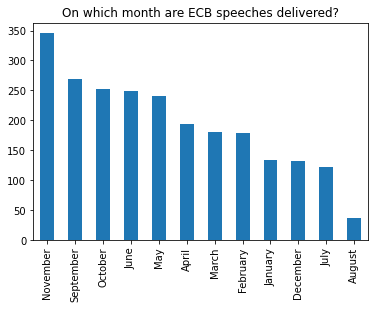

In [9]:
statdes.speech_months(df)

<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par Mois'}, xlabel='Mois'>

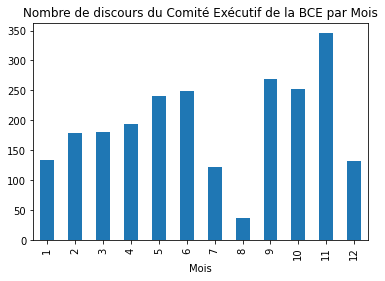

In [10]:
statdes.count_speeches(df, groupingby = 'Month', kind = 'bar')

On constate une forte saisonnalité des discours à la BCE : la plupart des discours sont prononcés pendant les trois mois de la "rentrée" (septembre, octobre, novembre) avec un maximum en novembre mais aussi dans une moindre mesure pendant les trois mois avant l'été (avril, mai, juin). Le nombre de discours chute pendant la période des vacances d'été (juillet et août), particulièrement en août.

### Nombre de discours selon les jours du mois

<AxesSubplot:title={'center':'Evolution du nombre de discours du Comité Exécutif de la BCE par Jour du mois'}, xlabel='Jour du mois'>

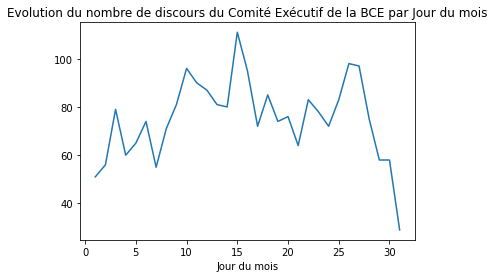

In [11]:
statdes.count_speeches(df, groupingby = 'Day', kind = 'line')

Les pics du graphique correspondent au milieu du mois qui est souvent le moment d'annonces sur les marchés et quelques jours avant la fin du mois.

<AxesSubplot:title={'center':'Nombre de discours du Comité Exécutif de la BCE par Jour de la semaine'}, xlabel='Jour de la semaine'>

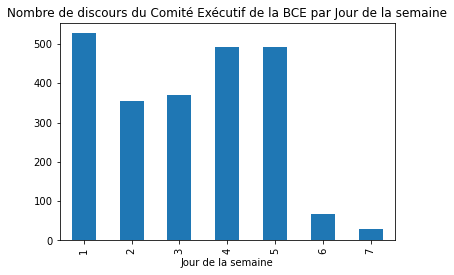

In [12]:
statdes.count_speeches(df, groupingby = 'DayofWeek', kind = 'bar')

On remarque que les discours de la BCE de notre échantillon ne sont pas répartis identiquement selon les jours de la semaine : ils sont majoritairement prononcés le premier jour de la semaine (lundi) et les deux jours avant le week-end (jeudi et vendredi), avec une chute conséquente le samedi et le dimanche, qui sont aussi les jours de fermeture des marchés boursiers dans le monde.

In [13]:
statdes.distinct_dates(df)

Il y a 1807 dates distinctes dans ce jeu de données, soit en moyenne environ 0.774 discours par jour.
Il y a 416 jours pour lesquels plus qu'un seul discours, soit 23.02 % de l'échantillon étudié.
Il y a 330 jours pour lesquels on a 2 discours.
Il y a 65 jours pour lesquels on a 3 discours.
Il y a 17 jours pour lesquels on a 4 discours.
Il y a 4 jours pour lesquels on a 5 discours.


### Orateurs les plus prolifiques du Comité Exécutif de la BCE depuis 1997

<Figure size 432x288 with 0 Axes>

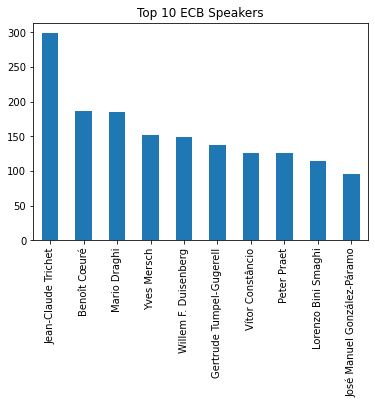

In [14]:
statdes.top_speakers(df, n=10)

Parmi les orateurs les plus prolifiques, on retrouve assez logiquement les anciens présidents de la BCE : Jean-Claude Trichet (2003-2011), Mario Draghi (20011-2019) et Willem Duisenberg (1998-2003) mais aussi Benoît Coeuré et Yves Mersch, membres du directoire de la Banque centrale européenne de 2012 à 2020.

## Exploration des discours avec du NLP

On utilise pour cela les fonctions du fichier *basic_nlp.py*.

In [15]:
# On prend un échantillon des discours 
# car on ne peut pas tous les mettre bout à bout
rawtext = basic_nlp.randomsample(df)
rawtext[:200]

'The productivity challenge for Europe  The productivity challenge for Europe   Lectio magistralis by Mario Draghi, President of the ECB, marking the 100th anniversary of the Deusto Business School, Ma'

### Reconnaissance d'entités nommées avec spacy

In [16]:
basic_nlp.named_entity(rawtext)

The productivity challenge for Europe  The productivity challenge for Europe   Lectio magistralis by Mario Draghi, President of the ECB, marking the 100th anniversary of the Deusto Business School, Madrid, 30 November 2016 The euro area economy continues to expand at a moderate, but steady, pace and labour markets are gradually improving, including notably here in Spain. This gradual upward trend is expected to continue, not least owing to our monetary policy measures. But productivity growth has remained very subdued. In 1995, productivity growth in the euro area was on a par with the rest of the world at about 2%. But now, at below 0.5%, it lags behind the growth rates of the United States, other advanced economies and emerging markets.     If it persists, this slowdown in productivity growth will matter greatly for our future prosperity, and will have direct consequences for the conduct of monetary and fiscal policy and the cohesion of the euro area.  Consider first the challenge ca

### Fréquence des mots

In [17]:
# On calcule la fréquence de chaque terme dans le texte
basic_nlp.freq_mots(rawtext)

Counter({'productivity': 31,
         'challenge': 11,
         'Europe': 23,
         'Lectio': 1,
         'magistralis': 1,
         'Mario': 2,
         'Draghi': 4,
         'President': 4,
         'ECB': 55,
         'marking': 1,
         'anniversary': 2,
         'Deusto': 1,
         'Business': 1,
         'School': 1,
         'Madrid': 1,
         'November': 2,
         'euro': 119,
         'area': 100,
         'economy': 19,
         'continues': 6,
         'expand': 1,
         'moderate': 2,
         'steady': 2,
         'pace': 2,
         'labour': 39,
         'markets': 27,
         'gradually': 2,
         'improving': 3,
         'including': 4,
         'notably': 5,
         'Spain': 9,
         'gradual': 3,
         'upward': 3,
         'trend': 5,
         'expected': 7,
         'continue': 7,
         'least': 5,
         'owing': 1,
         'monetary': 71,
         'policy': 78,
         'measures': 20,
         'But': 13,
         'growth': 44,
  

#### Liste des mots les plus fréquents dans l'échantillon de texte

In [19]:
basic_nlp.plus_frequents(rawtext, 20)

[['euro', 119],
 ['area', 100],
 ['policy', 78],
 ['monetary', 71],
 ['European', 60],
 ['financial', 58],
 ['ECB', 55],
 ['reforms', 55],
 ['economic', 46],
 ['Eurosystem', 46],
 ['growth', 44],
 ['banks', 42],
 ['stability', 42],
 ['non', 41],
 ['labour', 39],
 ['structural', 39],
 ['countries', 35],
 ['market', 35],
 ['unemployment', 33],
 ['macroprudential', 33]]

In [20]:
# On fait la même opération en retirant les stopwords et en tokenizant le texte
text = basic_nlp.tokens_filter(rawtext)
basic_nlp.word_counter(text, 20)

[('euro', 119),
 ('area', 100),
 ('policy', 78),
 ('monetary', 71),
 ('European', 60),
 ('financial', 58),
 ('ECB', 55),
 ('reforms', 55),
 ('economic', 46),
 ('Eurosystem', 46),
 ('growth', 44),
 ('banks', 42),
 ('stability', 42),
 ('non', 41),
 ('labour', 39),
 ('structural', 39),
 ('countries', 35),
 ('market', 35),
 ('unemployment', 33),
 ('macroprudential', 33)]

#### Bigrams
Les bigrams affichés sont les groupes de 2 mots les plus fréquents dans le texte. Le concept de n-grams est important en NLP car il permet de ne pas séparer des groupes de mots qui font sens ensemble comme ici : "euro area", "United States", "economic growth",...

In [21]:
bigrams = basic_nlp.get_bigrams(text)
basic_nlp.print_bigram_likelihood(bigrams)

(('euro', 'area'), 840.8405762894207)
(('monetary', 'policy'), 411.9736737788282)
(('Governing', 'Council'), 240.71543280741395)
(('price', 'stability'), 229.9437663951138)
(('structural', 'reforms'), 150.72293047380012)
(('labour', 'market'), 127.55087288660354)
(('United', 'States'), 121.42567903525914)
(('non', 'banks'), 118.00695891373988)
(('central', 'banks'), 99.42034807980502)
(('primary', 'objective'), 97.12918763086441)
(('productivity', 'growth'), 95.6312559590236)
(('ten', 'years'), 88.52054633269785)
(('Monetary', 'Union'), 87.11473747668276)
(('Single', 'Market'), 86.11522828903266)
(('financial', 'system'), 85.03109541030506)
(('medium', 'term'), 84.79578854787927)
(('non', 'bank'), 80.45369861570352)
(('reference', 'value'), 77.6377522521715)
(('long', 'term'), 75.69966774548202)
(('real', 'economy'), 74.78301005976417)
(('real', 'estate'), 74.55020819523104)
(('economic', 'growth'), 74.21002468728437)
(('exchange', 'rate'), 73.4451443537257)
(('labour', 'markets'), 72.

### Trigrams
Les trigrams semblent ici moins pertinents que les bigrams.

In [22]:
trigrams = basic_nlp.get_trigrams(text)
basic_nlp.print_trigram_likelihood(trigrams)

(('euro', 'area', 'countries'), 903.0277700826866)
(('growth', 'euro', 'area'), 870.8893482637319)
(('euro', 'area', 'economy'), 870.399488464723)
(('crisis', 'euro', 'area'), 859.555457240458)
(('across', 'euro', 'area'), 858.942422820664)
(('reforms', 'euro', 'area'), 845.6030943747586)
(('accommodative', 'monetary', 'policy'), 452.3180124876854)
(('monetary', 'policy', 'strategy'), 452.00123895808656)
(('monetary', 'policy', 'measures'), 440.3987060239282)
(('Eurosystem', 'monetary', 'policy'), 426.2212014163999)
(('ECB', 'monetary', 'policy'), 424.9645311740527)
(('maintain', 'price', 'stability'), 265.49742555303044)
(('objective', 'price', 'stability'), 262.204456166846)
(('ECB', 'Governing', 'Council'), 254.67501206328996)
(('Governing', 'Council', 'ECB'), 254.67501206328996)
(('labour', 'market', 'reforms'), 180.2909568375755)
(('rate', 'United', 'States'), 168.1623437553152)
(('national', 'central', 'banks'), 160.7123717630581)
(('non', 'bank', 'financial'), 130.13591310218595

## Termes les plus fréquents selon les années

C:\Users\Antoine\central-bank-speech-analysis\basic_nlp.py:197: UserWarning:

FixedFormatter should only be used together with FixedLocator



<BarContainer object of 10 artists>

<Figure size 432x288 with 0 Axes>

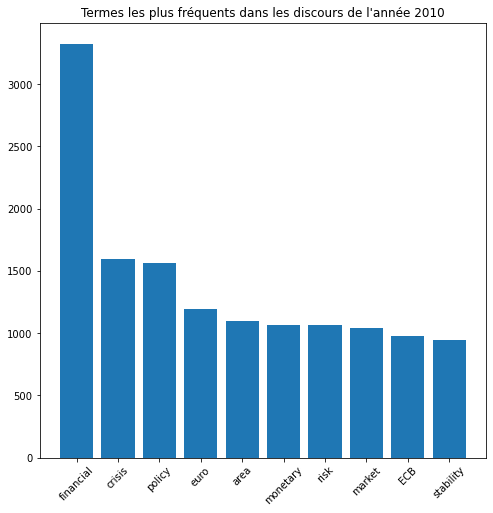

In [28]:
year = 2010
basic_nlp.plot_freq_word(df, year)

In [37]:
basic_nlp.freq_words_year(df, 2010, 20)

[('financial', 3327),
 ('crisis', 1593),
 ('policy', 1565),
 ('euro', 1192),
 ('area', 1095),
 ('monetary', 1067),
 ('risk', 1063),
 ('market', 1045),
 ('ECB', 980),
 ('stability', 948),
 ('banks', 938),
 ('economic', 937),
 ('European', 907),
 ('markets', 785),
 ('central', 765),
 ('system', 759),
 ('countries', 752),
 ('growth', 748),
 ('global', 745),
 ('economy', 701)]

# Latent Dirichlet Allocation (LDA)

LDA (short for Latent Dirichlet Allocation) is an unsupervised machine-learning model that takes documents as input and finds topics as output. The model also says in what percentage each document talks about each topic.

### Notebook établi à partir de : 
- https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb 
    - https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Reading data

In [41]:
data=df.sample(frac=0.6,random_state=1) # on n'applique la LDA que sur une portion du dataset pour pouvoir tester le modèle par la suite

#### Tokenization

In [42]:
data['sentences'] = data.contents.progress_map(nltk.tokenize.sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

  0%|          | 0/1400 [00:00<?, ?it/s]

['  Globalisation and central bank policies   Speech by Lucas Papademos, Vice President of the ECB,at the Bridge Forum Dialogue,Luxembourg, 22 January 2008      I.',
 'Introduction     For years now, globalisation has been, and continues to be, a buzzword in the public debate.',
 'Its persistent significance is certainly also due to the fact that it is such a multi-faceted phenomenon which has yet to be fully understood and assessed.']

In [43]:
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [nltk.tokenize.word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])

  0%|          | 0/1400 [00:00<?, ?it/s]

[['Globalisation', 'and', 'central', 'bank', 'policies', 'Speech', 'by', 'Lucas', 'Papademos', ',', 'Vice', 'President', 'of', 'the', 'ECB', ',', 'at', 'the', 'Bridge', 'Forum', 'Dialogue', ',', 'Luxembourg', ',', '22', 'January', '2008', 'I', '.'], ['Introduction', 'For', 'years', 'now', ',', 'globalisation', 'has', 'been', ',', 'and', 'continues', 'to', 'be', ',', 'a', 'buzzword', 'in', 'the', 'public', 'debate', '.'], ['Its', 'persistent', 'significance', 'is', 'certainly', 'also', 'due', 'to', 'the', 'fact', 'that', 'it', 'is', 'such', 'a', 'multi-faceted', 'phenomenon', 'which', 'has', 'yet', 'to', 'be', 'fully', 'understood', 'and', 'assessed', '.']]


#### Lemmatizing with POS tagging

In [44]:
#################################################################

# ETAPE LA PLUS CHRONOPHAGE
# 4 minutes pour 1400 discours

################################################################

data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [nltk.pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])

  0%|          | 0/1400 [00:00<?, ?it/s]

[[('Globalisation', 'NN'), ('and', 'CC'), ('central', 'JJ'), ('bank', 'NN'), ('policies', 'NNS'), ('Speech', 'NNP'), ('by', 'IN'), ('Lucas', 'NNP'), ('Papademos', 'NNP'), (',', ','), ('Vice', 'NNP'), ('President', 'NNP'), ('of', 'IN'), ('the', 'DT'), ('ECB', 'NNP'), (',', ','), ('at', 'IN'), ('the', 'DT'), ('Bridge', 'NNP'), ('Forum', 'NNP'), ('Dialogue', 'NNP'), (',', ','), ('Luxembourg', 'NNP'), (',', ','), ('22', 'CD'), ('January', 'NNP'), ('2008', 'CD'), ('I', 'PRP'), ('.', '.')], [('Introduction', 'NN'), ('For', 'IN'), ('years', 'NNS'), ('now', 'RB'), (',', ','), ('globalisation', 'NN'), ('has', 'VBZ'), ('been', 'VBN'), (',', ','), ('and', 'CC'), ('continues', 'VBZ'), ('to', 'TO'), ('be', 'VB'), (',', ','), ('a', 'DT'), ('buzzword', 'NN'), ('in', 'IN'), ('the', 'DT'), ('public', 'JJ'), ('debate', 'NN'), ('.', '.')], [('Its', 'PRP$'), ('persistent', 'JJ'), ('significance', 'NN'), ('is', 'VBZ'), ('certainly', 'RB'), ('also', 'RB'), ('due', 'JJ'), ('to', 'TO'), ('the', 'DT'), ('fact'

In [45]:
# Inspired from https://stackoverflow.com/a/15590384

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return ''

lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

In [46]:
# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

  0%|          | 0/1400 [00:00<?, ?it/s]

In [47]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['Globalisation',
  'and',
  'central',
  'bank',
  'policy',
  'Speech',
  'by',
  'Lucas',
  'Papademos',
  ',',
  'Vice',
  'President',
  'of',
  'the',
  'ECB',
  ',',
  'at',
  'the',
  'Bridge',
  'Forum',
  'Dialogue',
  ',',
  'Luxembourg',
  ',',
  '22',
  'January',
  '2008',
  'I',
  '.'],
 ['Introduction',
  'For',
  'year',
  'now',
  ',',
  'globalisation',
  'have',
  'be',
  ',',
  'and',
  'continue',
  'to',
  'be',
  ',',
  'a',
  'buzzword',
  'in',
  'the',
  'public',
  'debate',
  '.'],
 ['Its',
  'persistent',
  'significance',
  'be',
  'certainly',
  'also',
  'due',
  'to',
  'the',
  'fact',
  'that',
  'it',
  'be',
  'such',
  'a',
  'multi-faceted',
  'phenomenon',
  'which',
  'have',
  'yet',
  'to',
  'be',
  'fully',
  'understood',
  'and',
  'assessed',
  '.']]

#### Regrouping tokens and removing stop words

In [49]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
my_stopwords = set(list(basic_nlp.stop_words) + stopwords_verbs + stopwords_other)

In [50]:
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [51]:
data['tokens'].head(1).tolist()[0][:30]

['globalisation',
 'central',
 'bank',
 'policy',
 'speech',
 'lucas',
 'papademos',
 'vice',
 'president',
 'ecb',
 'bridge',
 'forum',
 'dialogue',
 'luxembourg',
 'january',
 'introduction',
 'year',
 'globalisation',
 'continue',
 'buzzword',
 'public',
 'debate',
 'persistent',
 'significance',
 'certainly',
 'due',
 'fact',
 'phenomenon',
 'yet',
 'fully']

## LDA

### Data preparation

#### Prepare bi-grams and tri-grams

In [52]:
tokens = data['tokens'].tolist()
bigram_model = gensim.models.Phrases(tokens)
trigram_model = gensim.models.Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [53]:
dictionary_LDA = gensim.corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

## Running LDA

In [54]:
np.random.seed(123456)
num_topics = 9
%time lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

Wall time: 30.2 s


## Quick exploration of LDA results

#### Looking at topics

In [56]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.003*"financial_stability" + 0.003*"banking_sector" + 0.002*"reform" + 0.002*"rule" + 0.002*"banking_union" + 0.002*"union" + 0.002*"ccps" + 0.002*"member_states" + 0.002*"supervision" + 0.002*"single_market" + 0.002*"approach" + 0.002*"strengthen" + 0.002*"liquidity" + 0.002*"share" + 0.002*"financial_system" + 0.002*"programme" + 0.002*"bring" + 0.002*"people" + 0.002*"regulation" + 0.002*"ssm"

1: 0.005*"liquidity" + 0.004*"government" + 0.003*"reform" + 0.003*"eurosystem" + 0.003*"financial_crisis" + 0.003*"financial_system" + 0.003*"fiscal" + 0.003*"financial_sector" + 0.002*"credit" + 0.002*"financial_stability" + 0.002*"integration" + 0.002*"system" + 0.002*"experience" + 0.002*"emu" + 0.002*"price_stability" + 0.002*"regulation" + 0.002*"member_states" + 0.002*"implement" + 0.002*"demand" + 0.002*"fiscal_policy"

2: 0.006*"eurosystem" + 0.006*"strategy" + 0.005*"statistic" + 0.004*"price_stability" + 0.004*"governing_council" + 0.004*"monetary_policy_strategy" + 0.004*"anal

Pour chaque topic, on a la "composition" du topic avec les mots qui le caractérise de par leur fréquence.

#### Allocating topics to documents

In [57]:
print(data.contents.loc[0][:500])

   SPEECH  The present and future of money in the digital age   Lecture by Fabio Panetta, Member of the Executive Board of the ECB  Rome, 10 December 2021 I would like to thank Federcasse for inviting me to speak at this edition of the Lectiones cooperativae. These lectures are an occasion to reflect on issues of broad significance and their implications for the application of the principles of cooperation. They offer us the opportunity to seek a deeper understanding of the changes taking place 


In [58]:
lda_model[corpus[0]]

[(3, 0.09809995), (4, 0.058989048), (5, 0.018494956), (7, 0.824389)]

#### Predicting topics on unseen document

In [59]:
document = '''The Governing Council judges that the progress on economic recovery and towards its medium-term inflation target permits a step-by-step reduction in the pace of its asset purchases over the coming quarters. But monetary accommodation is still needed for inflation to stabilise at the 2% inflation target over the medium term. In view of the current uncertainty, the Governing Council needs to maintain flexibility and optionality in the conduct of monetary policy. With this is mind, the Governing Council took the following decisions:

Pandemic emergency purchase programme (PEPP)
In the first quarter of 2022, the Governing Council expects to conduct net asset purchases under the PEPP at a lower pace than in the previous quarter. It will discontinue net asset purchases under the PEPP at the end of March 2022.

The Governing Council decided to extend the reinvestment horizon for the PEPP. It now intends to reinvest the principal payments from maturing securities purchased under the PEPP until at least the end of 2024. In any case, the future roll-off of the PEPP portfolio will be managed to avoid interference with the appropriate monetary policy stance.

The pandemic has shown that, under stressed conditions, flexibility in the design and conduct of asset purchases has helped to counter the impaired transmission of monetary policy and made efforts to achieve the Governing Council’s goal more effective. Within our mandate, under stressed conditions, flexibility will remain an element of monetary policy whenever threats to monetary policy transmission jeopardise the attainment of price stability. In particular, in the event of renewed market fragmentation related to the pandemic, PEPP reinvestments can be adjusted flexibly across time, asset classes and jurisdictions at any time. This could include purchasing bonds issued by the Hellenic Republic over and above rollovers of redemptions in order to avoid an interruption of purchases in that jurisdiction, which could impair the transmission of monetary policy to the Greek economy while it is still recovering from the fallout of the pandemic. Net purchases under the PEPP could also be resumed, if necessary, to counter negative shocks related to the pandemic.

Asset purchase programme (APP)
In line with a step-by-step reduction in asset purchases and to ensure that the monetary policy stance remains consistent with inflation stabilising at its target over the medium term, the Governing Council decided on a monthly net purchase pace of €40 billion in the second quarter and €30 billion in the third quarter under the APP. From October 2022 onwards, the Governing Council will maintain net asset purchases under the APP at a monthly pace of €20 billion for as long as necessary to reinforce the accommodative impact of its policy rates. The Governing Council expects net purchases to end shortly before it starts raising the key ECB interest rates.

The Governing Council also intends to continue reinvesting, in full, the principal payments from maturing securities purchased under the APP for an extended period of time past the date when it starts raising the key ECB interest rates and, in any case, for as long as necessary to maintain favourable liquidity conditions and an ample degree of monetary accommodation.

Key ECB interest rates
The interest rate on the main refinancing operations and the interest rates on the marginal lending facility and the deposit facility will remain unchanged at 0.00%, 0.25% and -0.50% respectively.

In support of its symmetric 2% inflation target and in line with its monetary policy strategy, the Governing Council expects the key ECB interest rates to remain at their present or lower levels until it sees inflation reaching 2% well ahead of the end of its projection horizon and durably for the rest of the projection horizon, and it judges that realised progress in underlying inflation is sufficiently advanced to be consistent with inflation stabilising at 2% over the medium term. This may also imply a transitory period in which inflation is moderately above target.

Refinancing operations
The Governing Council will continue to monitor bank funding conditions and ensure that the maturing of operations under the third series of targeted longer-term refinancing operations (TLTRO III) does not hamper the smooth transmission of its monetary policy. The Governing Council will also regularly assess how targeted lending operations are contributing to its monetary policy stance. As announced, it expects the special conditions applicable under TLTRO III to end in June next year. The Governing Council will also assess the appropriate calibration of its two-tier system for reserve remuneration so that the negative interest rate policy does not limit banks’ intermediation capacity in an environment of ample excess liquidity.

***

The Governing Council stands ready to adjust all of its instruments, as appropriate and in either direction, to ensure that inflation stabilises at its 2% target over the medium term.

The President of the ECB will comment on the considerations underlying these decisions at a press conference starting at 14:30 CET today.'''
tokens = nltk.tokenize.word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

,topic #,weight,words in topic
0,2,0.07,"0.006*""eurosystem"" + 0.006*""strategy"" + 0.005*..."
1,3,0.04,"0.003*""think"" + 0.003*""investment"" + 0.003*""pe..."
2,4,0.88,"0.003*""firm"" + 0.003*""reform"" + 0.003*""liquidi..."


## Advanced exploration of LDA results

#### Allocation of topics in all documents

In [60]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [61]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [62]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [63]:
document_topic.head()

,0,1,2,3,4,5,6,7,8
0,0.000000,0.000000,0.00000,0.098041,0.059010,0.018972,0.000000,0.823949,0.0
1,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.999770,0.000000,0.0
2,0.000000,0.529733,0.01018,0.000000,0.459977,0.000000,0.000000,0.000000,0.0
3,0.388569,0.000000,0.00000,0.574439,0.000000,0.036883,0.000000,0.000000,0.0
4,0.144796,0.000000,0.00000,0.000000,0.163046,0.000000,0.536983,0.147025,0.0


In [64]:
print("Moyenne de la part de chaque topic dans tout le texte")
for i in range(num_topics):
    print("Topic", i,":", document_topic.sort_values(i, ascending=False)[i].mean())

Moyenne de la part de chaque topic dans tout le texte
Topic 0 : 0.1218508118104988
Topic 1 : 0.10379226048476994
Topic 2 : 0.11450465699990413
Topic 3 : 0.12645108540542424
Topic 4 : 0.165453115071037
Topic 5 : 0.06768000113245631
Topic 6 : 0.04631467186712793
Topic 7 : 0.09321510128344276
Topic 8 : 0.15975286054691035


In [65]:
# Quels sont les discours sur le topic 1 ?
document_topic.sort_values(1, ascending=False)[1]

875     0.999950
233     0.999944
1315    0.999942
1353    0.999934
635     0.999931
          ...   
538     0.000000
537     0.000000
536     0.000000
535     0.000000
1399    0.000000
Name: 1, Length: 1400, dtype: float64

In [66]:
print(data.contents.loc[91][:1000])

   SPEECH  Fostering sustainable growth in Europe    Keynote speech by Christine Lagarde, President of the ECB, at the European Banking Congress Frankfurt am Main, 20 November 2020 The coronavirus (COVID-19) pandemic has rightly focused minds on the here and now – on saving lives and securing livelihoods. Our immediate priority has been to protect the economy until widespread immunity is achieved.[1] Yet the pandemic also provides the opportunity to reassess how we will organise our economy in the future. Today’s conference, on the topic of “Towards a New Sustainable Growth Model”, comes at just the right moment.  By necessity, the pandemic has accelerated our wider and more common use of digital technology. We have adjusted how we work, how we shop and how we pay. Nearly 50% of Europeans say they have worked from home during the pandemic. E-commerce increased by almost one-fifth during the first lockdown[2], and it stayed at that level even after restrictions were lifted. We have seen

#### Looking at the distribution of topics in all documents

#### Heatmap des topics sous forme de matrice diagonale

C:\Users\Antoine\anaconda3\lib\site-packages\seaborn\matrix.py:302: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

C:\Users\Antoine\anaconda3\lib\site-packages\seaborn\matrix.py:312: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



<AxesSubplot:>

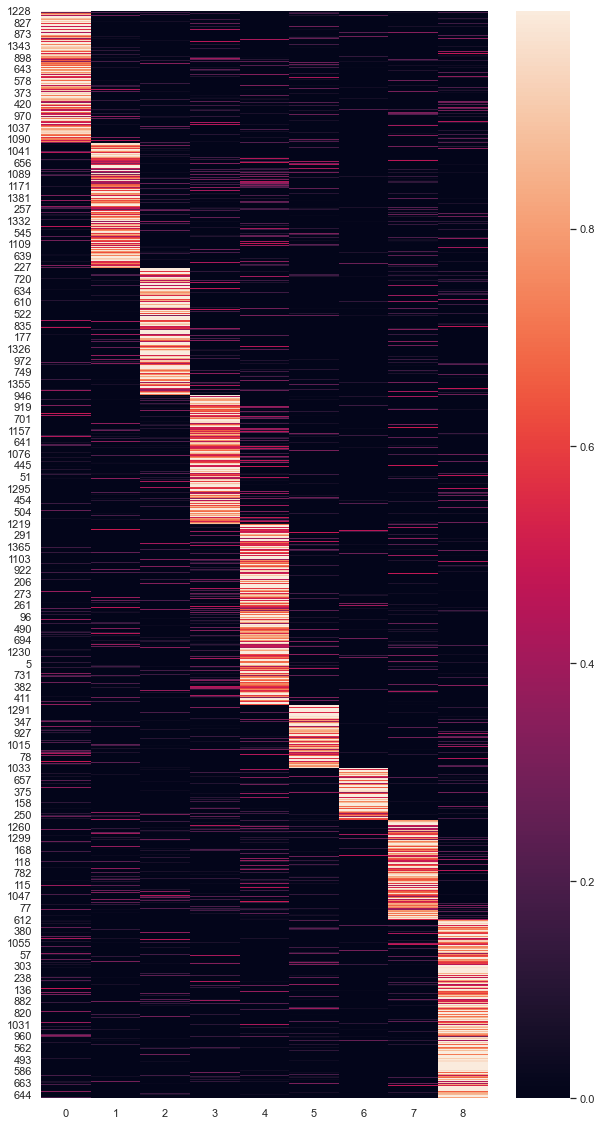

In [67]:
%matplotlib inline
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

Sur cette matrice/heatmap on voit les discours qui sont les plus proches en termes de topics abordés mais aussi la proportion de chaque topic dans l'ensemble des discours.

#### Importance de chaque topic dans l'échantillon de texte

<AxesSubplot:>

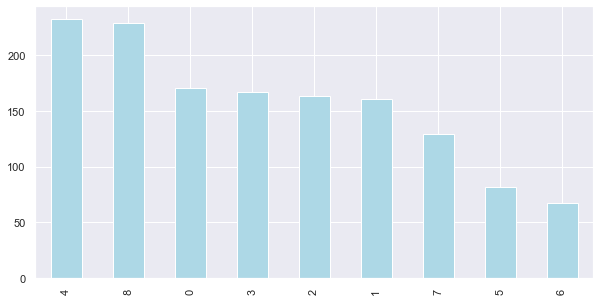

In [68]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#### Interactive topics visualization

In [69]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf

# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline

vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

C:\Users\Antoine\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



Cette visualisation interactive est la plus courante pour les LDA car elle permet d'afficher de nombreuses informations :
 - la taille de la bulle est proportionnelle aux proportions des sujets par rapport au total de N tokens dans le corpus.
 - les barres rouges représentent le nombre estimé de fois qu'un terme donné a été généré par un sujet donné.
 - les barres bleues représentent la fréquence globale de chaque terme dans le corpus.

De plus, on peut voir la distance "intertopic" sur un plan qui traduit la proximité sémantique entre les différents topics. Se pose alors la question du "recouvrement" entre topics et ainsi du nombre optimal de topics pour le modèle LDA spécifique à notre jeu de données.

Certains topics se démarquent particulièrement comme le 1, le 2 et le 5 tandis que les autres sont plutôt regroupés. Par ailleurs, certains mots ou bigrams reviennent quasiment dans tous les topics (financial stability par exemple), cela peut s'expliquer par l'importance de ces thèmes dans les activités de la BCE.

### LDA metrics : Perplexity et Coherence

La perplexity et la coherence sont deux métriques qui permettent d'évaluer les modèles de LDA.

In [70]:

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data['tokens'].tolist(),corpus=corpus, dictionary=dictionary_LDA, coherence='u_mass')
# coherence={'u_mass', 'c_v', 'c_uci', 'c_npmi'}
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_model_lda.get_coherence_per_topic())
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.52612089074178
[-1.252873796329216, -0.8225622744895181, -0.8120686264539422, -0.7870614595043862, -0.7186553501343175, -0.8740690317737819, -0.7896819981231377, -0.8410452659752808, -0.9524124237351217]

Coherence Score:  -0.8722700251687447


### Recherche du nombre optimal de topics pour notre modèle de LDA

In [71]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute 'u_mass' coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    complexity_values : Complexity values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    complexity_values= []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        complexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, complexity_values

In [ ]:
#########################################

# ETAPE CHRONOPHAGE (~10 minutes)

##########################################

start_time=time.time()

model_list, coherence_values, complexity_values = compute_coherence_values(dictionary=dictionary_LDA,
                                                                           corpus=corpus,
                                                                           texts=data['tokens'].tolist(),
                                                                           start=2,
                                                                           limit=20,
                                                                           step=1
                                                                          )
print("Temps pris par cette étape", time.time()-start_time) Temps pris par cette étape 509.70097303390503

In [ ]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, complexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Complexity score")
plt.title("Complexity score")
plt.legend(("complexity_values"), loc='best')
plt.show()

Différentes valeurs paraissent convenir pour le nombre de topics en relançant le code à plusieurs reprises : 3, 5, autour de 10 (entre 9 et 11 selon les essais) ou beaucoup plus.
Nous avons fait le choix de laisser dans notre notebook l'exemple avec 9 topics qui nous paraissait pertinent.

# Sentiment Analysis

Une autre manière d'analyser les discours est de faire de l'analyse de sentiments en utilisant des dictionnaires de mots positifs et négatifs.
Dans un premier temps, nous allons utiliser des librairies non spécialisées (AFINN et TextBlob) puis nous utiliserons des dictionnaires spécialement élaborés pour l'économie et la finance.

## Librairies non spécialisées

### AFINN
AFINN sentiment analysis in Python: Wordlist-based approach for sentiment analysis.

Finn Årup Nielsen, “A new ANEW: evaluation of a word list for sentiment analysis in microblogs”, Proceedings of the ESWC2011 Workshop on ‘Making Sense of Microposts’: Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

In [9]:
afinn = Afinn()
#exemple :
afinn.score('This is utterly excellent!')

3.0

In [11]:
#Premier test du score AFINN
start = time.time()
N=random.randrange(0, len(df))
print("Score :", afinn.score(df["contents"][N]))
end = time.time()
print("Temps pris :", end-start)
#Une première estimation donne une durée totale d'analyse d'un peu plus de 6 minutes pour tous les discours

Score : 88.0
Temps pris : 0.12486124038696289


In [12]:
start = time.time()

df["afinn-score"]=pd.Series(dtype=int)
def afinn_score(text):
    return afinn.score(text)

df["afinn-score"]=df["contents"].apply(afinn_score)

end = time.time()
print("Temps pris :", end-start) #~3 minutes

Temps pris : 230.49008059501648


Score moyen : 91.70522707797772
Score médian : 85.0


<AxesSubplot:>

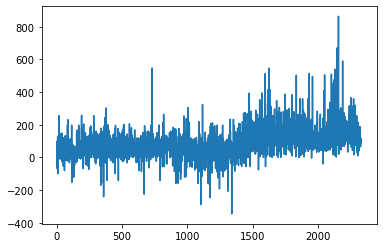

In [13]:
print("Score moyen :", df["afinn-score"].mean())
print("Score médian :",df["afinn-score"].median())

df["afinn-score"].plot()

In [14]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=90
fig=df.rolling(val, on="date").mean().plot(x="date",y="afinn-score",backend='plotly', title="Score AFINN")

fig.show()

## TextBlob

In [14]:
start = time.time()

df["textblob-score"]=pd.Series(dtype=int)
def textblob_score(text):
    return TextBlob(text).sentiment.polarity

df["textblob-score"]=df["contents"].apply(textblob_score)

end = time.time()
print("Temps pris :", end-start) #~40 secondes

Temps pris : 28.913647651672363


Score moyen : 0.1047167025466477
Score médian : 0.10119140438552868


<AxesSubplot:>

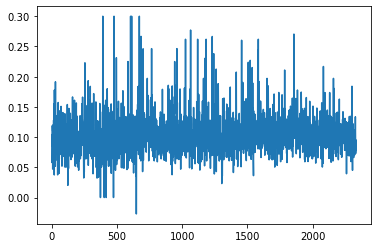

In [15]:
print("Score moyen :", df["textblob-score"].mean())
print("Score médian :",df["textblob-score"].median())

df["textblob-score"].plot()

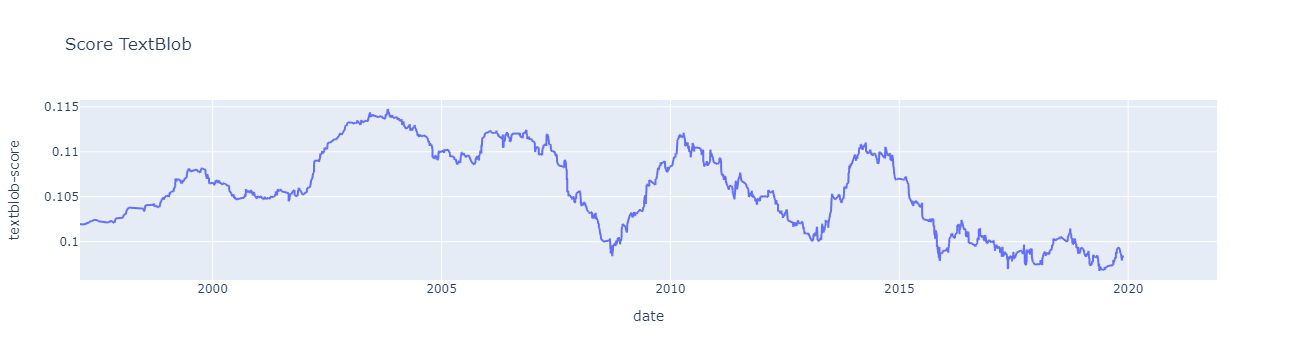

In [16]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=180
fig=df.rolling(val, on="date").mean().plot(x="date",y="textblob-score",backend='plotly', title="Score TextBlob")

fig.show()

## Corrélation entre les différents scores

In [17]:
df['afinn-score'].corr(df['textblob-score'])

0.13548532009111175

Les scores sont plus positifs que négatifs en général, mais il faudrait utiliser des librairies plus spécialisées (tournées vers l'économie et la finance).

# Librairies spécialisées

Au cours de nos recherches, plusieurs dictionnaires, listes ou bases de données sont apparus à plusieurs reprises comme des références dans l'analyse de sentiments de textes financiers comme :
- Loughran and McDonald
    - https://sraf.nd.edu/ et https://drive.google.com/file/d/1moS1tkh_AJafpcIFpktaSvZwrzv5d4ix/view
    - https://pypi.org/project/pysentiment2/#description 
- FED Financial Stability dictionary
    - https://www.federalreserve.gov/econres/notes/ifdp-notes/constructing-a-dictionary-for-financial-stability-20170623.htm
    - https://www.federalreserve.gov/econres/ifdp/files/ifdp1203.pdf [REPORT]
    - https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx [DATA]
- 
- Dataset "financial_phrasebank" https://huggingface.co/datasets/financial_phrasebank

## Loughran and McDonald

In [15]:
lm = ps.LM() #to use the Loughran and McDonald dictionary

     |████████████████████████████████| 1.9 MB 972 kB/s            


In [16]:
text=df["contents"][0]


tokens = lm.tokenize(text)
score = lm.get_score(tokens)

score

{'Positive': 125,
 'Negative': 165,
 'Polarity': -0.13793103400713436,
 'Subjectivity': 0.09244501112768728}

### Polarity

In [17]:
def LM_polarity(text):
    '''Pour obtenir la polarité d'un texte selon le dictionnaire Loughran and McDonald'''
    '''Polarity= (Pos-Neg)/(Pos+Neg)'''
    #lm = pysentiment2.LM() 
    #to use the Loughran and McDonald dictionary
    tokens = lm.tokenize(text)
    return round(lm.get_score(tokens)['Polarity'],4)

In [18]:
start = time.time()

df["LM-polarity"]=pd.Series(dtype=float)

df["LM-polarity"]=df["contents"].apply(LM_polarity)

end = time.time()
print("Temps pris :", end-start, "secondes")
#Temps pris : 110.3992772102356 secondes

Temps pris : 90.82716679573059 secondes


In [19]:
print("Polarité moyenne :", df["LM-polarity"].mean()) #Polarité moyenne : -0.04744399141630894

print("Polarité médiane :",df["LM-polarity"].median()) #Polarité médiane : -0.06055

Polarité moyenne : -0.04777600685518417
Polarité médiane : -0.06135


### Subjectivity

In [20]:
def LM_subjectivity(text):
    '''Pour obtenir la subjectivité d'un texte selon le dictionnaire Loughran and McDonald'''
    '''Subjectivity= (Pos+Neg)/count'''
    #lm = pysentiment2.LM() 
    #to use the Loughran and McDonald dictionary
    tokens = lm.tokenize(text)
    return round(lm.get_score(tokens)['Subjectivity'],4) #on arrondit le résultat

In [21]:
start = time.time()

df["LM-subjectivity"]=pd.Series(dtype=float)
df["LM-subjectivity"]=df["contents"].apply(LM_subjectivity)

end = time.time()
print("Temps pris :", end-start, "secondes")
#Temps pris : 114.29144740104675 secondes

In [22]:
print("Subjectivité moyenne :", df["LM-polarity"].mean()) #Subjectivité moyenne : -0.04744399141630894

print("Subjectivité médiane :",df["LM-polarity"].median()) #Subjectivité médiane : -0.06055

Subjectivité moyenne : -0.04777600685518417
Subjectivité médiane : -0.06135


### Graphiques Polarité et Subjectivité

In [23]:
fig = px.line(df, x="date",y=["LM-polarity","LM-subjectivity"])
fig.show()
#peu lisible

<AxesSubplot:xlabel='Year,Month'>

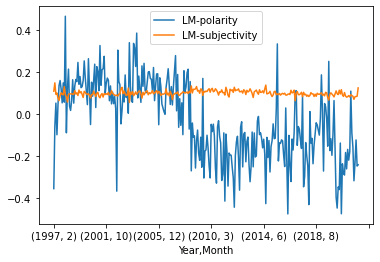

In [24]:
df1=df.groupby(["Year","Month"]).mean()
df1[["LM-polarity","LM-subjectivity"]].plot()
#une tendance se dégage pour la polarité

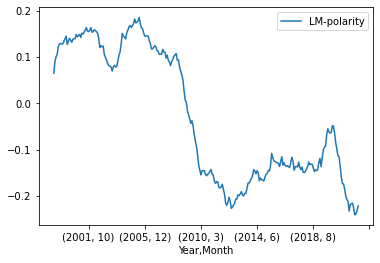

In [25]:
df2=df1.rolling(20).mean() #moyenne mobile sur 20 mois
fig=df2.plot(y="LM-polarity")

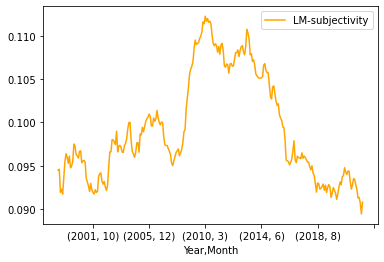

In [26]:
fig=df2.plot(y="LM-subjectivity", color='orange')

In [27]:
df.rolling(20, on="date").mean() #moyenne mobile sur 20 jours

,date,Day,DayofWeek,LM-polarity,LM-subjectivity,Month,Year,afinn-score
0,2021-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-11-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2329,1997-05-13,17.65,3.05,0.098085,0.087980,7.10,1997.25,117.85
2330,1997-04-30,18.90,3.00,0.092770,0.087755,7.20,1997.20,113.00
2331,1997-04-22,18.50,2.85,0.089275,0.089940,7.35,1997.15,109.60
2332,1997-03-10,17.90,2.70,0.076590,0.090130,7.45,1997.10,108.15


In [28]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=90
fig=df.rolling(val, on="date").mean().plot(x="date",y="LM-polarity",backend='plotly', title="Polarité")
fig.show()

In [29]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=200
fig=df.rolling(val, on="date").mean().plot(x="date",y="LM-subjectivity",backend='plotly', title="Subjectivité")

fig.show()

Les résultas obtenus semblent cohérents.

## FED Financial Stability dictionary

In [31]:
#FS Dictionary
fed1=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=1)

In [32]:
fed1
#ce format de dataframe n'est pas facile à exploiter
#on va le transformer en deux listes

,Word,Positive,Negative
0,able,1.0,NaN
1,abnormally,NaN,1.0
2,abrupt,NaN,1.0
3,absorb,1.0,NaN
4,absorbed,1.0,NaN
...,...,...,...
386,worsen,NaN,1.0
387,worsened,NaN,1.0
388,worsening,NaN,1.0
389,worst,NaN,1.0


In [33]:
positive_words=fed1[fed1["Positive"].notna()]["Word"]
positive_list=positive_words.values.tolist()
#positive_list

In [34]:
negative_words=fed1[fed1["Negative"].notna()]["Word"]
negative_list=negative_words.values.tolist()
#negative_list

In [35]:
#FS Dictionary print
fed2=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=2)
fed2
#on retrouve sous un autre format les mêmes informations que le premier dataframe

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Positive words,NaN,NaN,Negative words,NaN,NaN,NaN,NaN,NaN
1,able,mitigated,NaN,abnormally,destabilizing,exhausted,jeopardised,shortage,threats
2,absorb,mitigates,NaN,abrupt,deteriorate,expose,jeopardising,shortages,tough
3,absorbed,mitigating,NaN,abundant,deteriorated,exposed,jeopardize,shortfall,troubled
4,absorbing,mitigation,NaN,adverse,deteriorating,exposes,lackluster,shortfalls,tumbling
5,acceptable,opportunity,NaN,adversely,deterioration,exposing,lacklustre,shrank,turbulence
6,achievement,optimism,NaN,aggravate,deteriorations,fail,lagged,shrink,turbulences
7,adequately,outperformed,NaN,aggravated,detrimental,failed,lose,shrinking,turbulent
8,alleviated,positive,NaN,aggravating,difficult,failing,losing,shrunk,turmoil
9,alleviating,positively,NaN,aggravation,difficulties,fails,losses,slid,unable


In [36]:
#Non FS words
fed3=pd.read_excel(r"https://www.federalreserve.gov/econres/ifdp/files/ifdp1203-appendix.xlsx", sheet_name=3)
fed3

,Word,Non-FS (neutral),
0,abandoned,1,NaN
1,abate,1,NaN
2,abated,1,NaN
3,abnormal,1,NaN
4,abolition,1,NaN
...,...,...,...
1088,underpriced,1,NaN
1089,unfolded,1,NaN
1090,unnecessary,1,NaN
1091,uplift,1,NaN


In [37]:
neutral_list=fed3["Word"].values.tolist()
#neutral_list

### Calcul des deux grandeurs : FSS index et excitement index

Ces deux grandeurs sont celles mentionnées dans le rapport associé au dictionnaire de la FED. (federalreserve.gov/econres/ifdp/files/ifdp1203.pdf)

FSS index : $$   FSS=(Negativewords - Positivewords)/(Totalwords) $$

Excitement index : $$   FSS*=(Negativewords^2 + Positivewords^2)/(Totalwords) $$

In [42]:
def FSS_index(text,positive_words=positive_list,negative_words=negative_list):
    '''Pour calculer le FSS index décrit dans le rapport de la FED'''
    '''FSS=(Negativewords - Positivewords)/(Totalwords)'''
    #positive_words et negative_words sont des listes
    negative_count=0
    positive_count=0
    L=basic_nlp.liste_mots(text)
    for word in L:
        if (word in positive_words):
            positive_count+=1
        elif (word in negative_words):
            negative_count+=1
    return round((negative_count-positive_count)*100/len(L),3)

In [43]:
def excitement_index(text,positive_words=positive_list,negative_words=negative_list):
    '''Pour calculer l'excitement index décrit dans le rapport de la FED'''
    '''FSS*=(Negativewords^2 + Positivewords^2)/(Totalwords)'''
    #positive_words et negative_words sont des listes
    negative_count=0
    positive_count=0
    L=basic_nlp.liste_mots(text)
    for word in L:
        if (word in positive_words):
            positive_count+=1
        elif (word in negative_words):
            negative_count+=1
    return round((negative_count**2+positive_count**2)/len(L),3)

In [44]:
start=time.time()

df["FSS-index"]=df["contents"].apply(FSS_index)

print("Temps pris :",time.time()-start) #41.49177670478821

Temps pris : 44.84216570854187


In [45]:
start=time.time()

df["excitement-index"]=df["contents"].apply(excitement_index)

print("Temps pris :",time.time()-start) #43.82283163070679

Temps pris : 35.41240930557251


In [46]:
fig = px.line(df, x="date",y=["FSS-index","excitement-index"])
fig.show()

In [47]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=300
fig=df.rolling(val, on="date").mean().plot(x="date",y="FSS-index",backend='plotly', title="FSS-index")

fig.show()

In [48]:
#pour demander un input de la période
#val=int(input("Période en jours de la moyenne mobile :"))

val=300
fig=df.rolling(val, on="date").mean().plot(x="date",y="excitement-index",backend='plotly', title="excitement-index")

fig.show()

## Dataset "financial_phrasebank"

In [ ]:
dataset = datasets.load_dataset("financial_phrasebank", 'sentences_allagree')

In [ ]:
pd.DataFrame.from_dict(dataset)

# Régression linéaire et random forest

On charge le fichier contenant les différentes analyses de sentiments

In [134]:
url = "https://minio.lab.sspcloud.fr/aissac/Projet_Python_2A/sentiment_analysis_speeches_dataset.csv"

df = pd.read_csv(url,sep = ",",encoding='utf-8', index_col = ["date"])


On enlève certaines colonnes, en particulier contents qui prend beaucoup de place

In [150]:
df.index.rename("Date")
df.index = df.index.map(pd.to_datetime)
daily_df = df.drop(columns=['Unnamed: 0','title','subtitle','contents']).groupby(df.index).mean()
daily_df

,Year,Month,Day,DayofWeek,afinn-score,textblob-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index
date,,,,,,,,,,
1997-02-07,1997.0,2.0,7.0,5.0,95.0,0.094710,-0.3544,0.1085,0.524000,0.908
1997-03-10,1997.0,3.0,10.0,1.0,90.0,0.089926,-0.0583,0.1481,1.150000,1.538
1997-04-22,1997.0,4.0,22.0,2.0,95.0,0.077731,-0.0074,0.1133,0.477000,0.589
1997-04-30,1997.0,4.0,30.0,3.0,118.0,0.090242,0.1111,0.0736,-0.292000,0.149
1997-05-13,1997.0,5.0,13.0,2.0,107.0,0.072848,-0.0984,0.0993,0.327000,0.283
...,...,...,...,...,...,...,...,...,...,...
2021-11-25,2021.0,11.0,25.0,4.0,127.0,0.110057,-0.5062,0.0723,-0.204000,0.182
2021-11-26,2021.0,11.0,26.0,5.0,73.0,0.110466,-0.4940,0.0668,0.179000,0.111
2021-11-29,2021.0,11.0,29.0,1.0,47.0,0.118910,-0.1719,0.0831,0.979000,0.941


On charge différent modules de sklearn

In [151]:
le = preprocessing.LabelEncoder()
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)

On s'intéresse à STOXX50, qui est un indice boursier au niveau de la zone euro. Au même titre que le CAC 40 pour la France, l'EURO STOXX 50 regroupe 50 sociétés selon leur capitalisation boursière au sein de la zone euro

In [152]:
estx50='^STOXX50E'
#récupération des données
data=yf.Ticker(estx50)
#récupération prix
estx50_df= data.history(periode='1d', start='1997-01-01', end='2022-01-05')

estx50_df['HML']=estx50_df['High']-estx50_df['Low'] #High minus Low
estx50_df['CMO']=estx50_df['Close']-estx50_df['Open'] #Close minus Open
estx50_df['Daily Variation']=estx50_df.apply(lambda row: 100*(row.Close - row.Open)/row.Open, axis = 1)
estx50_df['Daily Volatility']=estx50_df.apply(lambda row: 100*abs(row.CMO)/row.Open, axis = 1)
estx50_df['HML Volatility']=estx50_df.apply(lambda row: 100*abs(row.HML)/row.Open, axis = 1)
estx50_df=estx50_df.drop(columns=['Open','High','Low','Close','Volume','Dividends','Stock Splits'])

#afficher les données
estx50_df

,HML,CMO,Daily Variation,Daily Volatility,HML Volatility
Date,,,,,
2007-03-30,47.409668,3.359863,0.080424,0.080424,1.134835
2007-04-02,27.989746,12.239746,0.293005,0.293005,0.670042
2007-04-03,48.529785,46.759766,1.113450,1.113450,1.155598
2007-04-04,19.780273,9.120117,0.214454,0.214454,0.465122
2007-04-05,20.379883,11.560059,0.271364,0.271364,0.478403
...,...,...,...,...,...
2021-12-28,32.580078,21.390137,0.498542,0.498542,0.759347
2021-12-29,41.080078,-26.299805,-0.610044,0.610044,0.952884
2021-12-30,24.250000,19.439941,0.453502,0.453502,0.565712


On s'intéresse également à l'évolution du cours EURO / DOLLAR

In [153]:
eurusd_df=yf.download('EURUSD=X')
eurusd_df['HML']=eurusd_df['High']-eurusd_df['Low'] #High minus Low
eurusd_df['CMO']=eurusd_df['Close']-eurusd_df['Open'] #Close minus Open
eurusd_df['Daily Variation']=eurusd_df.apply(lambda row: 100*(row.Close - row.Open)/row.Open, axis = 1)
eurusd_df['Daily Volatility']=eurusd_df.apply(lambda row: 100*abs(row.CMO)/row.Open, axis = 1)
eurusd_df['HML Volatility']=eurusd_df.apply(lambda row: 100*abs(row.HML)/row.Open, axis = 1)
eurusd_df=eurusd_df.drop(columns=['Open','High','Low','Close','Adj Close'])
eurusd_df

[*********************100%***********************]  1 of 1 completed


,Volume,HML,CMO,Daily Variation,Daily Volatility,HML Volatility
Date,,,,,,
2003-12-01,0,0.009606,-0.006897,-0.573125,0.573125,0.798260
2003-12-02,0,0.016303,0.012797,1.069873,1.069873,1.362988
2003-12-03,0,0.005303,0.003298,0.272771,0.272771,0.438629
2003-12-04,0,0.010004,-0.003909,-0.322562,0.322562,0.825443
2003-12-05,0,0.012503,0.010892,0.901826,0.901826,1.035198
...,...,...,...,...,...,...
2021-12-31,0,0.007410,0.000180,0.015855,0.015855,0.654390
2022-01-03,0,0.009051,-0.000039,-0.003406,0.003406,0.795770
2022-01-04,0,0.004955,0.000026,0.002268,0.002268,0.438444


In [154]:
df1=daily_df.join(eurusd_df)
df1=df1.dropna()
df1

,Year,Month,Day,DayofWeek,afinn-score,textblob-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index,Volume,HML,CMO,Daily Variation,Daily Volatility,HML Volatility
date,,,,,,,,,,,,,,,,
2003-12-01,2003.0,12.0,1.0,1.0,138.0,0.074949,0.0200,0.1009,0.000000,0.731,0.0,0.009606,-0.006897,-0.573125,0.573125,0.798260
2003-12-03,2003.0,12.0,3.0,3.0,144.0,0.131415,0.4030,0.1056,-0.759000,0.228,0.0,0.005303,0.003298,0.272771,0.272771,0.438629
2003-12-10,2003.0,12.0,10.0,3.0,69.0,0.105858,0.5833,0.0541,-0.743000,0.030,0.0,0.010398,-0.005809,-0.474227,0.474227,0.848865
2004-01-15,2004.0,1.0,15.0,4.0,80.0,0.126981,0.3514,0.0649,-0.383000,0.083,0.0,0.010209,-0.005502,-0.434734,0.434734,0.806632
2004-01-16,2004.0,1.0,16.0,5.0,113.0,0.140738,0.3333,0.0503,-0.761000,0.086,0.0,0.024603,-0.020199,-1.603070,1.603070,1.952580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,2021.0,11.0,25.0,4.0,127.0,0.110057,-0.5062,0.0723,-0.204000,0.182,0.0,0.002693,-0.000402,-0.035847,0.035847,0.240270
2021-11-26,2021.0,11.0,26.0,5.0,73.0,0.110466,-0.4940,0.0668,0.179000,0.111,0.0,0.011400,0.000063,0.005594,0.005594,1.017081
2021-11-29,2021.0,11.0,29.0,1.0,47.0,0.118910,-0.1719,0.0831,0.979000,0.941,0.0,0.003915,0.000204,0.018064,0.018064,0.346759


In [155]:
df2=daily_df.join(estx50_df)
df2=df1.dropna()
df2

,Year,Month,Day,DayofWeek,afinn-score,textblob-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index,Volume,HML,CMO,Daily Variation,Daily Volatility,HML Volatility
date,,,,,,,,,,,,,,,,
2003-12-01,2003.0,12.0,1.0,1.0,138.0,0.074949,0.0200,0.1009,0.000000,0.731,0.0,0.009606,-0.006897,-0.573125,0.573125,0.798260
2003-12-03,2003.0,12.0,3.0,3.0,144.0,0.131415,0.4030,0.1056,-0.759000,0.228,0.0,0.005303,0.003298,0.272771,0.272771,0.438629
2003-12-10,2003.0,12.0,10.0,3.0,69.0,0.105858,0.5833,0.0541,-0.743000,0.030,0.0,0.010398,-0.005809,-0.474227,0.474227,0.848865
2004-01-15,2004.0,1.0,15.0,4.0,80.0,0.126981,0.3514,0.0649,-0.383000,0.083,0.0,0.010209,-0.005502,-0.434734,0.434734,0.806632
2004-01-16,2004.0,1.0,16.0,5.0,113.0,0.140738,0.3333,0.0503,-0.761000,0.086,0.0,0.024603,-0.020199,-1.603070,1.603070,1.952580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,2021.0,11.0,25.0,4.0,127.0,0.110057,-0.5062,0.0723,-0.204000,0.182,0.0,0.002693,-0.000402,-0.035847,0.035847,0.240270
2021-11-26,2021.0,11.0,26.0,5.0,73.0,0.110466,-0.4940,0.0668,0.179000,0.111,0.0,0.011400,0.000063,0.005594,0.005594,1.017081
2021-11-29,2021.0,11.0,29.0,1.0,47.0,0.118910,-0.1719,0.0831,0.979000,0.941,0.0,0.003915,0.000204,0.018064,0.018064,0.346759


On regarde la correlation entre les différents coefficients

In [156]:
# To find the correlation among
# the columns using pearson method
df1.corr(method ='pearson')
#df1.corr(method ='kendall')

,Year,Month,Day,DayofWeek,afinn-score,textblob-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index,Volume,HML,CMO,Daily Variation,Daily Volatility,HML Volatility
Year,1.000000,0.029655,-0.009017,-0.035783,-0.343179,-0.120323,-0.298109,-0.174473,0.036695,-0.080571,NaN,-0.077952,-0.024749,-0.025234,-0.517436,-0.076605
Month,0.029655,1.000000,-0.112873,-0.003746,-0.028685,-0.028537,-0.075184,-0.004779,0.051571,0.017946,NaN,-0.036931,0.022740,0.023287,-0.069423,-0.037393
Day,-0.009017,-0.112873,1.000000,0.009640,0.030023,0.016701,0.037797,-0.005823,-0.049618,-0.030524,NaN,0.003614,0.010062,0.009530,0.041481,0.003910
DayofWeek,-0.035783,-0.003746,0.009640,1.000000,-0.040540,-0.022036,-0.026516,0.056641,0.073256,0.032973,NaN,-0.025867,0.034587,0.037381,0.032820,-0.023213
afinn-score,-0.343179,-0.028685,0.030023,-0.040540,1.000000,0.159020,0.497417,-0.188644,-0.404905,-0.164827,NaN,0.006319,0.031134,0.029433,0.185758,0.006366
textblob-score,-0.120323,-0.028537,0.016701,-0.022036,0.159020,1.000000,0.168336,-0.213992,-0.373184,-0.263459,NaN,-0.016636,0.020530,0.020183,0.030154,-0.017666
LM-polarity,-0.298109,-0.075184,0.037797,-0.026516,0.497417,0.168336,1.000000,-0.136884,-0.633131,-0.325968,NaN,0.021364,0.035610,0.037569,0.172911,0.020777
LM-subjectivity,-0.174473,-0.004779,-0.005823,0.056641,-0.188644,-0.213992,-0.136884,1.000000,0.411051,0.521615,NaN,0.048861,-0.000606,-0.001367,0.097292,0.050116
FSS-index,0.036695,0.051571,-0.049618,0.073256,-0.404905,-0.373184,-0.633131,0.411051,1.000000,0.508019,NaN,0.011622,-0.016613,-0.016282,-0.002344,0.012380
excitement-index,-0.080571,0.017946,-0.030524,0.032973,-0.164827,-0.263459,-0.325968,0.521615,0.508019,1.000000,NaN,0.014179,0.012857,0.012759,0.066359,0.016413


In [157]:
df2.corr(method ='pearson')

,Year,Month,Day,DayofWeek,afinn-score,textblob-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index,Volume,HML,CMO,Daily Variation,Daily Volatility,HML Volatility
Year,1.000000,0.029655,-0.009017,-0.035783,-0.343179,-0.120323,-0.298109,-0.174473,0.036695,-0.080571,NaN,-0.077952,-0.024749,-0.025234,-0.517436,-0.076605
Month,0.029655,1.000000,-0.112873,-0.003746,-0.028685,-0.028537,-0.075184,-0.004779,0.051571,0.017946,NaN,-0.036931,0.022740,0.023287,-0.069423,-0.037393
Day,-0.009017,-0.112873,1.000000,0.009640,0.030023,0.016701,0.037797,-0.005823,-0.049618,-0.030524,NaN,0.003614,0.010062,0.009530,0.041481,0.003910
DayofWeek,-0.035783,-0.003746,0.009640,1.000000,-0.040540,-0.022036,-0.026516,0.056641,0.073256,0.032973,NaN,-0.025867,0.034587,0.037381,0.032820,-0.023213
afinn-score,-0.343179,-0.028685,0.030023,-0.040540,1.000000,0.159020,0.497417,-0.188644,-0.404905,-0.164827,NaN,0.006319,0.031134,0.029433,0.185758,0.006366
textblob-score,-0.120323,-0.028537,0.016701,-0.022036,0.159020,1.000000,0.168336,-0.213992,-0.373184,-0.263459,NaN,-0.016636,0.020530,0.020183,0.030154,-0.017666
LM-polarity,-0.298109,-0.075184,0.037797,-0.026516,0.497417,0.168336,1.000000,-0.136884,-0.633131,-0.325968,NaN,0.021364,0.035610,0.037569,0.172911,0.020777
LM-subjectivity,-0.174473,-0.004779,-0.005823,0.056641,-0.188644,-0.213992,-0.136884,1.000000,0.411051,0.521615,NaN,0.048861,-0.000606,-0.001367,0.097292,0.050116
FSS-index,0.036695,0.051571,-0.049618,0.073256,-0.404905,-0.373184,-0.633131,0.411051,1.000000,0.508019,NaN,0.011622,-0.016613,-0.016282,-0.002344,0.012380
excitement-index,-0.080571,0.017946,-0.030524,0.032973,-0.164827,-0.263459,-0.325968,0.521615,0.508019,1.000000,NaN,0.014179,0.012857,0.012759,0.066359,0.016413


On sépare le dataset en un jeu de donnée d'entrainement et un autre de test de prédiction

In [161]:
Y_train = df1["Daily Variation"][:1200]
Y_test = df1["Daily Variation"][1200:]
X_train = df1[["Year", "Month", "Day", "DayofWeek", "afinn-score", "textblob-score", "LM-polarity", "LM-subjectivity", "FSS-index", "excitement-index"]].iloc[:1200]
X_test = df1[["Year", "Month", "Day", "DayofWeek", "afinn-score", "textblob-score", "LM-polarity", "LM-subjectivity", "FSS-index", "excitement-index"]].iloc[1200:]

On obtient ces résultats pour la régression linéaire pour euro/usd

Slope: [-4.69465894e-04  3.60677008e-03  6.29268127e-04  1.17355666e-02
  5.28868739e-05  3.22585386e-01  6.81629737e-02 -2.41655374e-01
  4.87398707e-03  1.83497683e-02]
Intercept: 0.8581111080150471
R2: -2.500218481767589


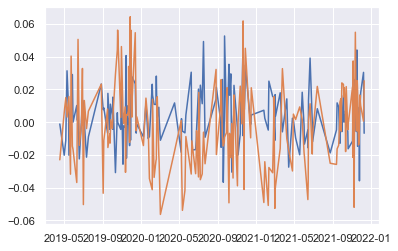

In [163]:
lr = lr.fit(X_train, Y_train)
print('Slope:' ,lr.coef_)
print('Intercept:', lr.intercept_)
print('R2:',lr.score(X_test, Y_test))
plt.plot(Y_test.index, Y_test)
plt.plot(Y_test.index, lr.predict(X_test))

In [166]:
X_train2 = df2[["Year", "Month", "Day", "DayofWeek", "afinn-score", "textblob-score", "LM-polarity", "LM-subjectivity", "FSS-index", "excitement-index"]].iloc[:1200]
X_test2 = df2[["Year", "Month", "Day", "DayofWeek", "afinn-score", "textblob-score", "LM-polarity", "LM-subjectivity", "FSS-index", "excitement-index"]].iloc[1200:]

On obtient ces résultats pour la régression linéaire pour EUROSTOXX

Slope: [-4.69465894e-04  3.60677008e-03  6.29268127e-04  1.17355666e-02
  5.28868739e-05  3.22585386e-01  6.81629737e-02 -2.41655374e-01
  4.87398707e-03  1.83497683e-02]
Intercept: 0.8581111080150471
R2: -2.500218481767589


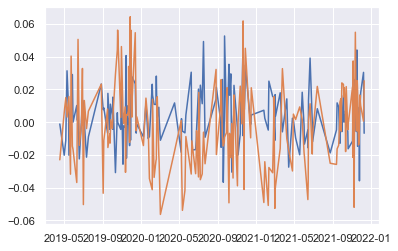

In [168]:
lr = lr.fit(X_train2, Y_train)
print('Slope:' ,lr.coef_)
print('Intercept:', lr.intercept_)
print('R2:',lr.score(X_test2, Y_test))
plt.plot(Y_test.index, Y_test)
plt.plot(Y_test.index, lr.predict(X_test2))


On encode dans le nom de la personne qui prononce le discours dans une dummy variable

In [173]:
df["speakers"] = le.fit_transform(df["speakers"])
daily_df = df.drop(columns=['Unnamed: 0','title','subtitle','contents']).groupby(df.index).mean()


features=daily_df.join(eurusd_df["Daily Variation"]).dropna() #.apply(np.sign) pour les Classifier
#features = pd.get_dummies(features) ???
features

,speakers,Year,Month,Day,DayofWeek,afinn-score,textblob-score,LM-polarity,LM-subjectivity,FSS-index,excitement-index,Daily Variation
date,,,,,,,,,,,,
2003-12-01,9.000000,2003.0,12.0,1.0,1.0,138.0,0.074949,0.0200,0.1009,0.000000,0.731,-0.573125
2003-12-03,9.000000,2003.0,12.0,3.0,3.0,144.0,0.131415,0.4030,0.1056,-0.759000,0.228,0.272771
2003-12-10,4.000000,2003.0,12.0,10.0,3.0,69.0,0.105858,0.5833,0.0541,-0.743000,0.030,-0.474227
2004-01-15,9.000000,2004.0,1.0,15.0,4.0,80.0,0.126981,0.3514,0.0649,-0.383000,0.083,-0.434734
2004-01-16,9.000000,2004.0,1.0,16.0,5.0,113.0,0.140738,0.3333,0.0503,-0.761000,0.086,-1.603070
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-25,6.000000,2021.0,11.0,25.0,4.0,127.0,0.110057,-0.5062,0.0723,-0.204000,0.182,-0.035847
2021-11-26,3.000000,2021.0,11.0,26.0,5.0,73.0,0.110466,-0.4940,0.0668,0.179000,0.111,0.005594
2021-11-29,3.000000,2021.0,11.0,29.0,1.0,47.0,0.118910,-0.1719,0.0831,0.979000,0.941,0.018064


In [174]:
# Labels are the values we want to predict
labels = np.array(features['Daily Variation'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('Daily Variation', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 1)

In [175]:
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=1)

In [176]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.16


In [178]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Year                 Importance: 0.13
Variable: afinn-score          Importance: 0.11
Variable: textblob-score       Importance: 0.11
Variable: LM-polarity          Importance: 0.1
Variable: LM-subjectivity      Importance: 0.1
Variable: FSS-index            Importance: 0.1
Variable: excitement-index     Importance: 0.1
Variable: Month                Importance: 0.08
Variable: Day                  Importance: 0.08
Variable: speakers             Importance: 0.05
Variable: DayofWeek            Importance: 0.04


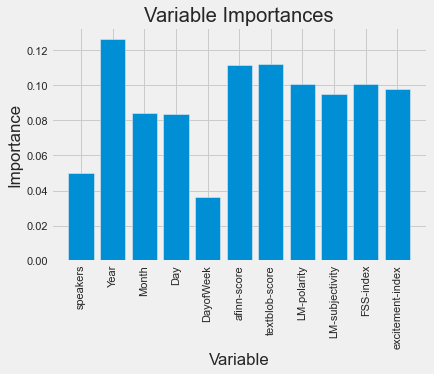

In [179]:
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

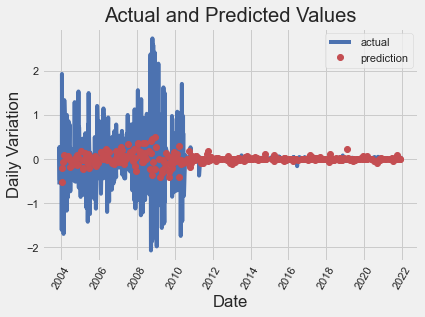

In [182]:

# Dates of training values
months = features[:, feature_list.index('Month')]
days = features[:, feature_list.index('Day')]
years = features[:, feature_list.index('Year')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# Dates of predictions
months = test_features[:, feature_list.index('Month')]
days = test_features[:, feature_list.index('Day')]
years = test_features[:, feature_list.index('Year')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Daily Variation'); plt.title('Actual and Predicted Values');

In [183]:
df=pd.concat([true_data,predictions_data],axis = 1, join = 'inner')
df

,date,actual,date,prediction
0,2003-12-01,-0.573125,2016-11-09,0.006382
1,2003-12-03,0.272771,2016-11-14,0.002343
2,2003-12-10,-0.474227,2017-07-25,0.000071
3,2004-01-15,-0.434734,2017-09-22,0.004479
4,2004-01-16,-1.603070,2004-11-12,0.083994
...,...,...,...,...
409,2009-09-21,-0.005877,2008-09-26,0.415859
410,2009-09-24,-0.041024,2013-10-03,0.008776
411,2009-09-25,0.000000,2019-05-23,-0.040641
412,2009-09-28,-0.046792,2011-06-07,0.011968


In [184]:
# Pour un random forest Classifier sur la hausse ou la baisse (output binaire)
# df['OK']= df['actual']==df['prediction']
# df['OK'].sum()/len(predictions_data.date)


0.0